# Text Classification Assessment

This assessment is a text classification project where the goal is to classify the genre of a movie based on its characteristics, primarily the text of the plot summarization. You have a training set of data that you will use to identify and create your best predicting model. Then you will use that model to predict the classes of the test set of data. We will compare the performance of your predictions to your classmates using the F1 Score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The **movie_train.csv** dataset contains information (`Release Year`, `Title`, `Plot`, `Director`, `Cast`) about 10,682 movies and the label of `Genre`. There are 9 different genres in this data set, so this is a multiclass problem. You are expected to primarily use the plot column, but can use the additional columns as you see fit.

After you have identified yoru best performing model, you will create predictions for the test set of data. The test set of data, contains 3,561 movies with all of their information except the `Genre`. 

Below is a list of tasks that you will definitely want to complete for this challenge, but this list is not exhaustive. It does not include any tasds around handling class imbalance or about how to test multiple different models and their tuning parameters, but you should still look at doing those to see if they help you to create a better predictive model.


# Good Luck

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [4]:
from nltk.corpus import RegexpTokenizer as regextoken

In [6]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM, GRU
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")


In [7]:
from chart_studio.plotly import iplot

In [8]:
from imblearn.over_sampling import SMOTE

### Task #1: Perform imports and load the dataset into a pandas DataFrame


In [9]:
import pandas as pd
train = pd.read_csv('movie_train.csv')

In [10]:
test = pd.read_csv('movie_test.csv')

### Task #2: Check for missing values:

In [9]:
train.Genre.value_counts()

drama        3770
comedy       2724
horror        840
action        830
thriller      685
romance       649
western       525
adventure     331
crime         328
Name: Genre, dtype: int64

In [24]:
train.Genre.value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Genres', 
                                                                title='Movie Genre#')

In [28]:
def print_plot(index):
    example = train[train.index == index][['Plot', 'Plot']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Plot:', example[1])

In [29]:
print_plot(10)


Vazhthugal revolves around Kathiravan, a successful entrepreneur who manages a software company. Kathiravan is an affectionate son and socially responsible too. His company is involved in various social activities.
When his close friend's parents are forced by their daughter-in-law to leave home, Kathrivan decides to marry a girl who will keep his parents happy. While watching a television programme he is impressed by Kayal, a college student from Coimbatore being interviewed on a show.
To a question by the interviewer, 'where do you see yourself in another ten years?' Kayal deviating from the usual clichéd answers replies, "As an ideal wife, mother and daughter-in-law." And during the course of her talk, she attributes her success to her large and loving family consisting of her parents, maternal grandfather, aunts, uncles and cousins. Kathiravan is impressed with her attitude and feels that she is the right life companion for him.
He goes to Coimbatore to woo her. But meeting her in 

In [10]:
# Check for NaN values:
train.isnull().sum().sum()

169

In [11]:
# Check for whitespace strings (it's OK if there aren't any!):
import string
def contains_whitespace(s):
    return True in [c in s for c in string.whitespace]
contains_whitespace(train['Plot'])

False

### Task #3: Remove NaN values:

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


In [13]:
train['cleanplot'] = train['Plot'].apply(clean_text)

# Unique tokens on plot

In [43]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['Plot1'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 92392 unique tokens.


### Task #4: Take a look at the columns and do some EDA to familiarize yourself with the data. 

### Task #5: Split the data into train & test sets:

Yes we have a holdout set of the data, but you do not know the genres of that data, so you can't use it to evaluate your models. Therefore you must create your own training and test sets to evaluate your models. 

In [25]:
stop = stopwords.words("english")
print(stop)
stop.extend(["one", "n", "nan", "x"])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [26]:
# Creating a regular expression tokenizer that matches only alphabets
# This will return separate words (tokens) from the text
tokenizer = regextoken("[a-zA-Z]+") 
# Applying the tokenizer to each row of the reviews
review_tokens = train["cleanplot"].apply(tokenizer.tokenize)
# Examining the tokens created for the first row / restaurant
print(review_tokens[0])

['computer', 'error', 'leads', 'accidental', 'release', 'homicidal', 'patient', 'howard', 'johns', 'mental', 'institution', 'mute', 'murderer', 'returns', 'scene', 'original', 'crimes']


In [28]:
from nltk import FreqDist, bigrams, trigrams

In [29]:
# Removing stopwords from the tokens
review_tokens = review_tokens.apply(lambda x: [token for token in x if token not in stop])
# Concatenating all the reviews 
all_reviews = review_tokens.astype(str).str.cat()
cleaned_reviews = tokenizer.tokenize(all_reviews)

# Getting the frequency distribution of individual words in the reviews
fd = FreqDist()
for word in cleaned_reviews:
    fd[word] += 1
    
# Examining the top 5 most frequent words
fd.most_common(5)

[('back', 6672),
 ('tells', 6374),
 ('father', 6128),
 ('two', 6090),
 ('home', 5679)]

In [30]:
review_tokens

0        [computer, error, leads, accidental, release, ...
1        [lonnie, wilson, ken, scott, son, sharecropper...
2        [gaunt, bushybearded, yearold, wes, holman, re...
3        [ram, avtar, childhood, best, friends, differe...
4        [machete, cortez, danny, trejo, sartana, river...
                               ...                        
10677    [nick, sanders, comes, home, war, needs, job, ...
10678    [film, covers, first, half, novel, ends, truce...
10679    [sam, gold, jesse, eisenberg, mildmannered, ye...
10680    [yankee, lawyer, john, reynolds, john, wayne, ...
10681    [somewhat, fictionalized, account, destruction...
Name: cleanplot, Length: 10682, dtype: object

In [15]:
df = train[pd.notnull(train['cleanplot'])]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10681
Data columns (total 8 columns):
Unnamed: 0      10682 non-null int64
Release Year    10682 non-null int64
Title           10682 non-null object
Plot            10682 non-null object
Director        10682 non-null object
Cast            10513 non-null object
Genre           10682 non-null object
cleanplot       10682 non-null object
dtypes: int64(2), object(6)
memory usage: 751.1+ KB


In [17]:
df['genre_id'] = df['Genre'].factorize()[0]
from io import StringIO
genre_id_df = df[['Genre', 'genre_id']].drop_duplicates().sort_values('genre_id')
genre_to_id = dict(genre_id_df.values)
id_to_genre = dict(genre_id_df[['genre_id', 'Genre']].values)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.cleanplot).toarray()
labels = df.genre_id
features.shape

(10682, 46570)

In [26]:
genre_to_id

{'horror': 0,
 'drama': 1,
 'action': 2,
 'western': 3,
 'comedy': 4,
 'romance': 5,
 'thriller': 6,
 'crime': 7,
 'adventure': 8}

In [28]:
from sklearn.feature_selection import chi2
import numpy as np
import collections

N = 100
result = collections.defaultdict(list)
for Genre, genre_id in sorted(genre_to_id.items()):
    features_chi2 = chi2(features, labels == genre_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #print("# '{}':".format(Genre))
    #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    result[Genre] += unigrams[-N:]
    
print(result)

defaultdict(<class 'list'>, {'action': ['reddys', 'injustice', 'triads', 'han', 'arts', 'raghuvaran', 'cm', 'gant', 'officer', 'charan', 'honest', 'undercover', 'compound', 'leader', 'bomb', 'abhimanyu', 'politician', 'dharma', 'fighters', 'trafficker', 'inspector', 'hyderabad', 'vigilante', 'chopper', 'cops', 'amrish', 'shilpa', 'chakraborty', 'narasimha', 'ajay', 'azad', 'chennai', 'shafi', 'kingpin', 'drug', 'dsp', 'norris', 'villains', 'fbi', 'vidyarthi', 'suraj', 'maha', 'killed', 'henchman', 'andhra', 'kidnapped', 'ops', 'fights', 'goons', 'arjun', 'shetty', 'weapons', 'killing', 'raja', 'gowda', 'jeanclaude', 'shankar', 'ranjith', 'shiva', 'helicopter', 'chinna', 'ninjas', 'baddies', 'reddy', 'sudeep', 'revenge', 'commissioner', 'balakrishna', 'mission', 'rowdies', 'damme', 'cia', 'hostages', 'defeats', 'devaraj', 'prakash', 'mercenaries', 'nandamuri', 'kills', 'terrorist', 'underworld', 'gang', 'raj', 'interpol', 'police', 'rambo', 'mla', 'mafia', 'babu', 'kill', 'cop', 'corrup

In [29]:
pd.DataFrame(result)

,action,adventure,comedy,crime,drama,horror,romance,thriller,western
0,reddys,clans,betty,killer,farm,cat,know,implying,union
1,injustice,voyage,sachs,strangled,zamindar,frankensteins,suri,patrice,rangers
2,triads,greeks,pitch,racy,million,spirits,poonam,nishan,tomahawk
3,han,zenda,bowery,yard,1941,upstairs,rich,hamburg,custers
4,arts,ivory,murders,clerks,marries,room,kavi,safe,bandit
...,...,...,...,...,...,...,...,...,...
95,vijay,natives,kills,della,jewish,possessed,chetan,caller,saloon
96,ninja,dartagnan,killed,heist,relationship,vampires,varun,murders,stagecoach
97,henchmen,ship,comedy,criminal,kill,werewolf,reema,murder,indians
98,terrorists,pirates,stooges,triad,emotional,creature,rahul,phone,cattle


In [24]:
unigrams[-10:]

['outlaws',
 'outlaw',
 'marshal',
 'posse',
 'rancher',
 'saloon',
 'stagecoach',
 'indians',
 'cattle',
 'ranch']

In [25]:
bigrams[-10:]

['american civil',
 'hired gun',
 'land baron',
 'rides town',
 'randolph scott',
 'audie murphy',
 'jesse james',
 'civil war',
 'cattle drive',
 'wagon train']

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42),
    LinearSVC(),
    MultinomialNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

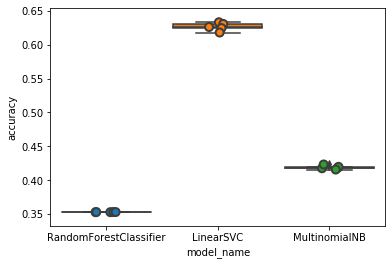

In [113]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [32]:
cv_df.groupby('model_name').accuracy.mean()

NameError: name 'cv_df' is not defined

In [ ]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, Y_train)

In [ ]:
# finding the unigram and bigram that correlate with both genres

In [115]:
model.fit(features, labels)
N = 2
for Genre, genre_id in sorted(genre_to_id.items()):
    indices = np.argsort(model.coef_[genre_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Genre))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# 'action':
  . Top unigrams:
       . police
       . kill
  . Top bigrams:
       . police officer
       . falls love
# 'adventure':
  . Top unigrams:
       . ship
       . captain
  . Top bigrams:
       . united states
       . net day
# 'comedy':
  . Top unigrams:
       . new
       . love
  . Top bigrams:
       . new york
       . net day
# 'crime':
  . Top unigrams:
       . police
       . murder
  . Top bigrams:
       . prime suspect
       . scotland yard
# 'drama':
  . Top unigrams:
       . life
       . family
  . Top bigrams:
       . falls love
       . new york
# 'horror':
  . Top unigrams:
       . body
       . house
  . Top bigrams:
       . net day
       . net morning
# 'romance':
  . Top unigrams:
       . love
       . father
  . Top bigrams:
       . falls love
       . fall love
# 'thriller':
  . Top unigrams:
       . police
       . murder
  . Top bigrams:
       . net day
       . new york
# 'western':
  . Top unigrams:
       . town
       . ranch
  . 

### Task #6: Build a pipeline to vectorize the date, then train and fit your models.
You should train multiple types of models and try different combinations of the tuning parameters for each model to obtain the best one. You can use the SKlearn functions of GridSearchCV and Pipeline to help automate this process.


### Task #7: Run predictions and analyze the results on the test set to identify the best model.  

In [ ]:
# Form a prediction set


In [ ]:
# Report the confusion matrix



In [ ]:
# Print a classification report


In [ ]:
# Print the overall accuracy and F1 score


In [70]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(train) * .7)
train_posts = train['cleanplot'][:train_size]
train_tags = train['Genre'][:train_size]

test_posts = train['cleanplot'][train_size:]
test_tags = train['Genre'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

In [ ]:
#kERAS

In [ ]:
data = shuffle(train)


i = 8
data_to_predict = data[:i].reset_index(drop = True)
predict_species = data_to_predict.Species 
predict_species = np.array(predict_species)
prediction = np.array(data_to_predict.drop(['Species'],axis= 1))

data = data[i:].reset_index(drop = True)

### Task #8: Refit the model to all of your data and then use that model to predict the holdout set. 

### #9: Save your predictions as a csv file that you will send to the instructional staff for evaluation. 

## Great job!